In [253]:
import sys
import os
sys.path.insert(0, os.path.expanduser('~/prod_covid19_spread'))
import metrics
import pandas
import plotly.express as px
import sqlite3
from forecast_db import DB, to_sql
import yaml
from datetime import timedelta
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import functools
from sqlalchemy import create_engine
from datetime import date
%matplotlib inline

In [254]:
conn = sqlite3.connect(':memory:')
with sqlite3.connect(DB) as conn_:
    conn_.backup(conn)
# conn = create_engine('postgresql:///covid19')

In [255]:
loc_map = {
    'new-jersey': {'loc1': 'United States', 'loc2': 'New Jersey'},
    'nystate': {'loc1': 'United States', 'loc2': 'New York'},
    'at': {'loc1': 'Austria'}
}
gt_map = {
    'new-jersey': 'nyt_ground_truth',
    'nystate': 'nyt_ground_truth',
    'at': 'austria_ground_truth',
}

In [256]:
forecast_pth = '/checkpoint/mattle/covid19/forecasts/nystate/2020_06_11_09_05/forecasts/forecast_best_mae.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/at/2020_06_22_11_08/forecasts/forecast_best_mae.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/at/2020_06_25_09_00/forecasts/forecast_best_rmse.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/nystate/2020_06_25_08_50/forecasts/forecast_best_mae.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/nystate/2020_07_01_09_20/forecasts/forecast_best_mae.csv'
forecast_pth = '/checkpoint/mattle/covid19/forecasts/nystate/2020_07_09_08_32_07/forecasts/forecast_best_mae.csv'

forecast_pth = os.environ.get('FORECAST_PTH', forecast_pth)

cfg = yaml.safe_load(open(os.path.dirname(forecast_pth) + '/../cfg.yml'))
loc_cols = [f'loc{k}' for k in range(1, len(loc_map[cfg['region']]) + 2)]
nlocs = len(loc_map[cfg["region"]]) + 1
df = pandas.read_csv(forecast_pth, index_col='date', parse_dates=['date'])
var_name = f'loc{len(loc_map[cfg["region"]]) + 1}'
df = df.reset_index().melt(id_vars=['date'], value_name='counts', var_name=var_name)
for k, v in loc_map[cfg['region']].items():
    df[k] = v

df['id'] = 'cv_ar'
df['forecast_date'] = (df['date'].min() - timedelta(days=1)).date()
FORECAST_DATE = (df['date'].min() - timedelta(days=1)).date()
to_sql(conn, df, 'infections')
basedate = (df['date'].min() - timedelta(days=1)).date()

In [257]:
cond = ' AND '.join([f"inf.{k}='{v}'" for k, v in loc_map[cfg['region']].items()])
cond += f' AND inf.loc{nlocs} IS NOT NULL'

In [258]:
dates = ', '.join([f"'{d}'" for d in df['date'].dt.date.unique()])
spatial_join = ', '.join([f'loc{i}' for i in range(1, nlocs + 1)])

gt = pandas.read_sql(
    f"SELECT * FROM infections inf WHERE forecast_date IS NULL AND {cond} AND id='{gt_map[cfg['region']]}'", 
    conn, 
    parse_dates=['date']
)

q = f"""
SELECT inf.loc1, inf.loc2, inf.loc3, inf.date, inf.id, inf.counts, inf.forecast_date
FROM infections inf
WHERE {cond}
    AND inf.date >= '{basedate - timedelta(days=7)}'
    AND inf.forecast_date >= '{basedate - timedelta(days=7)}' 
    AND inf.forecast_date <= '{basedate}' 
    AND inf.forecast_date IS NOT NULL
"""
forecasts = pandas.read_sql(q, conn, parse_dates=['date', 'forecast_date'])
forecasts['forecast_date'] = forecasts['forecast_date'].dt.date

In [259]:
group_loc = f'loc{len(loc_map[cfg["region"]])}'
grouped = forecasts.groupby([group_loc, 'id', 'forecast_date', 'date']).sum().reset_index()
grouped['color'] = grouped['forecast_date'].apply(str) + '_' + grouped['id']

# Largest Divergence

#### A list of counties with the largest divergence from the previous forecast

In [260]:
last_date = forecasts[forecasts['id'] == f'cv_ar']['forecast_date'].max()
locs = [f'loc{i}' for i in range(1, len(loc_map[cfg['region']]) + 2)]
suffixes = ('_this_forecast', f'_{last_date}')
df1 = forecasts[(forecasts['id'] == 'cv_ar') & (forecasts['forecast_date'] == FORECAST_DATE)]
df2 = forecasts[(forecasts['id'] == 'cv_ar') & (forecasts['forecast_date'] < FORECAST_DATE)]
df2 = forecasts[forecasts['forecast_date'] == forecasts['forecast_date'].max()]
x = df1.merge(df2, on=locs + ['date'], suffixes=suffixes)
x['diff'] = (x['counts_this_forecast'] - x[f'counts_{last_date}']).abs()
x['days_out'] = x['date'].dt.date - x['forecast_date_this_forecast']
cols = locs + ['date', 'days_out', 'counts_this_forecast', f'counts_{last_date}', 'diff']
worst = x.loc[x.groupby(locs)['diff'].idxmax()].sort_values(by='diff', ascending=False)[cols].iloc[:10]
worst

,loc1,loc2,loc3,date,days_out,counts_this_forecast,counts_2020-07-09,diff
1418,United States,New York,Queens,2020-07-16,7 days,66757.040550,66549.0,208.040550
823,United States,New York,Kings,2020-07-16,7 days,61096.537514,60975.5,121.037514
88,United States,New York,Bronx,2020-07-16,7 days,48515.523018,48621.5,105.976982
1068,United States,New York,New York,2020-07-16,7 days,29429.550625,29337.5,92.050625
1804,United States,New York,Suffolk,2020-07-16,7 days,42206.367214,42266.5,60.132786
1139,United States,New York,Oneida,2020-07-16,7 days,1897.582086,1863.5,34.082086
1244,United States,New York,Orange,2020-07-16,7 days,10905.397915,10875.5,29.897915
1034,United States,New York,Nassau,2020-07-16,7 days,42430.952728,42457.5,26.547272
508,United States,New York,Erie,2020-07-16,7 days,7885.886894,7860.5,25.386894
1174,United States,New York,Onondaga,2020-07-16,7 days,3190.024458,3214.5,24.475542


# Forecast Trajectories

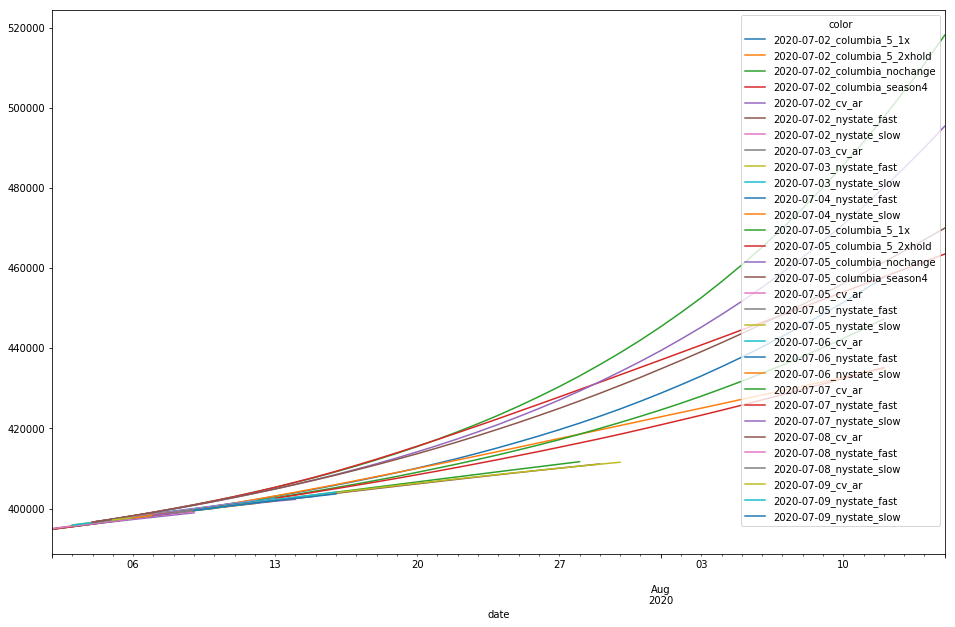

In [261]:
fig = grouped.pivot(index='date', columns='color', values='counts').plot(figsize=(16, 10))

# Mean Absolute Error

In [262]:
forecasts['loc'] = functools.reduce(lambda x, y: y + ', ' + x, [forecasts[col] for col in loc_cols])
gt_pivot = gt.copy()
gt_pivot['loc'] = functools.reduce(lambda x, y: y + ', ' + x, [gt_pivot[col] for col in loc_cols])
gt_pivot = gt_pivot.pivot(index='date', columns='loc', values='counts')

ms = []
for (mdl_id, forecast_date), group in forecasts.groupby(['id', 'forecast_date']):
    group = group.pivot(index='date', columns='loc', values='counts')
    if len(group.index.intersection(gt_pivot.index)) == 0:
        continue
    m = metrics._compute_metrics(gt_pivot, group)
    m = m.transpose().sort_index().rename_axis('date').reset_index()
    m['forecast_date'] = forecast_date
    m['id'] = mdl_id
    ms.append(m)
ms = pandas.concat(ms)
with pandas.option_context('display.max_rows', None):
    display(ms.set_index(['forecast_date', 'id', 'date'])['MAE'].to_frame().sort_index())

MAE
forecast_date id                date                 
2020-07-02    columbia_5_1x     2020-07-02   5.822581
                                2020-07-03  11.241935
                                2020-07-04  13.290323
                                2020-07-05  12.903226
                                2020-07-06  15.596774
                                2020-07-07  18.258065
                                2020-07-08  21.032258
                                2020-07-09  25.354839
                                2020-07-10  29.693548
                                2020-07-11  34.887097
                                2020-07-12  41.177419
              columbia_5_2xhold 2020-07-02   5.806452
                                2020-07-03  11.290323
                                2020-07-04  13.387097
                                2020-07-05  12.951613
                                2020-07-06  15.403226
                                2020-07-07  18.306452
                                2020-07-08  21.177419
                                2020-07-09  25.516129
                                2020-07-10  29.919355
                                2020-07-11  35.048387
                                2020-07-12  41.435484
              columbia_nochange 2020-07-02   5.887097
                                2020-07-03  11.435484
                                2020-07-04  13.709677
                                2020-07-05  13.145161
                                2020-07-06  15.387097
                                2020-07-07  18.193548
                                2020-07-08  20.919355
                                2020-07-09  24.532258
                                2020-07-10  28.306452
                                2020-07-11  33.129032
                                2020-07-12  38.580645
              columbia_season4  2020-07-02   5.774194
                                2020-07-03  11.403226
                                2020-07-04  13.741935
                                2020-07-05  13.000000
                                2020-07-06  14.887097
                                2020-07-07  17.532258
                                2020-07-08  20.435484
                                2020-07-09  23.758065
                                2020-07-10  27.532258
                                2020-07-11  32.854839
                                2020-07-12  37.661290
              cv_ar             2020-07-03   5.971060
                                2020-07-04   8.552905
                                2020-07-05   8.099661
                                2020-07-06   8.057039
                                2020-07-07   9.616009
                                2020-07-08  12.904740
                                2020-07-09  14.025845
              nystate_fast      2020-07-02   0.000000
                                2020-07-03   4.854839
                                2020-07-04   6.500000
                                2020-07-05   5.838710
                                2020-07-06   7.943548
                                2020-07-07   8.596774
                                2020-07-08  11.725806
                                2020-07-09  14.354839
              nystate_slow      2020-07-02   0.000000
                                2020-07-03   5.129032
                                2020-07-04   6.975806
                                2020-07-05   6.427419
                                2020-07-06   7.854839
                                2020-07-07   8.580645
                                2020-07-08  11.370968
                                2020-07-09  13.411290
2020-07-03    cv_ar             2020-07-04   2.695738
                                2020-07-05   3.991574
                                2020-07-06   4.792212
                                2020-07-07   6.071919
                                2020-07-08   8.480081
                                2020-07-09   9.921162


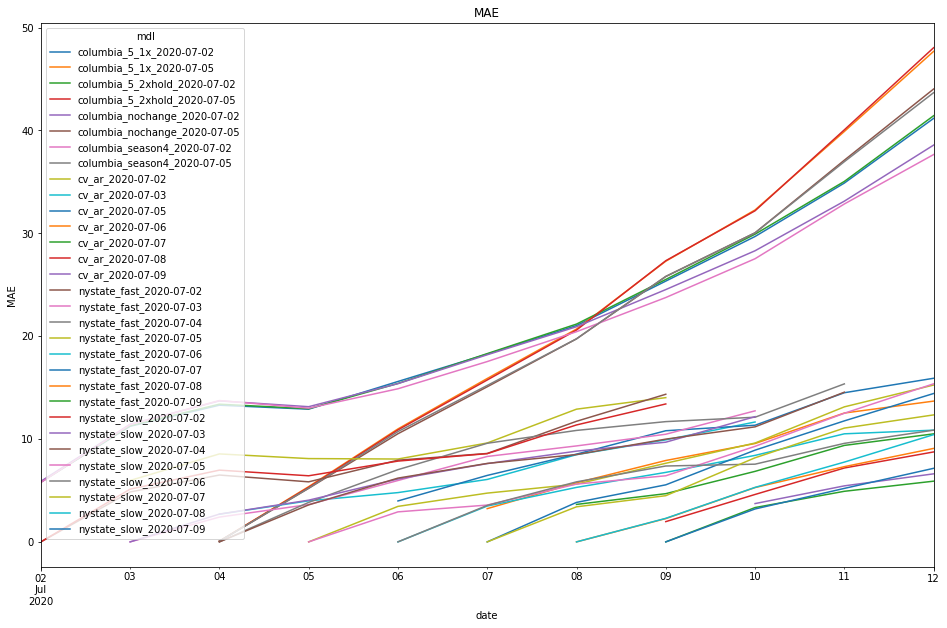

In [263]:
ms['mdl'] = ms['id'] + '_' + ms['forecast_date'].astype(str)
# ms.set_index(['mdl', 'date']).plot('MAE')
# ms.set_index(['mdl', 'date'])

fig = ms.pivot(index='date', columns='mdl', values='MAE').plot(figsize=(16, 10), title='MAE')
_ = plt.ylabel('MAE')